### **Przewidywanie wartości składki na ubezpieczenie zdrowotne na podstawie cech osoby ubezpieczonej**

Cechy osoby ubezpieczonej:

*   age (wiek) - wiek osoby ubezpieczonej podany w latach,
*   sex (płeć) - płeć osoby ubezpieczonej (male lub female),
*   bmi (wskaźnik BMI) - wskaźnik masy ciała osoby ubezpieczonej wyrażony wzorem $\frac{masa}{wzrost^2}$ (jednostka $\frac{kg}{m^2}$),
*   children (dzieci) - liczba dzieci objętych ubezpieczeniem,
*   smoker (palacz) - określa, czy osoba ubezpieczona pali papierosy (yes lub no),
*   region (region) - region USA, w którym zamieszkuje osoba ubezpieczona (northeast, southeast, northwest lub southwest).

Wartość składki na ubezpieczenie zdrowotne:
* charges (składki) - indywidualne koszty leczenia naliczane przez ubezpieczenie zdrowotne (waluta $)

Na podstawie cech osoby ubezpieczonej będziemy przewidywać wartość składki na ubezpieczenie zdrowotne.  

### Import potrzebnych bibliotek

Importujemy potrzebne biblioteki.



In [25]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, Normalizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from math import sqrt
import pandas as pd
import numpy as np


### Pobranie danych z datasetu do ramki danych o nazwie data

Pobieramy dane z datasetu do ramki danych i wyświetlamy dane.

In [26]:
data = pd.read_csv("/content/dataset.csv")
data

,age,sex,bmi,children,smoker,region,charges
0,37,male,34.100,4,yes,southwest,40182.24600
1,18,male,34.430,0,no,southeast,1137.46970
2,23,female,36.670,2,yes,northeast,38511.62830
3,32,male,35.200,2,no,southwest,4670.64000
4,58,female,32.395,1,no,northeast,13019.16105
...,...,...,...,...,...,...,...
1333,62,female,30.495,2,no,northwest,15019.76005
1334,41,male,28.405,1,no,northwest,6664.68595
1335,57,male,40.280,0,no,northeast,20709.02034
1336,30,female,39.050,3,yes,southeast,40932.42950


### Oczyszczanie zbioru danych

Sprawdzamy, czy w którejś kolumnie występują wartości wybrakowane. \\
Jak widać poniżej, nie ma takich wartości i nie musimy przeprowadzić oczyszczania zbioru danych.

In [27]:
data.isnull().any(axis=0)

age         False
sex         False
bmi         False
children    False
smoker      False
region      False
charges     False
dtype: bool

### Transformacja wartości

Nasza ramka danych posiada 7 kolumn. \\
Wartości kolumn age, bmi, children i charges są wartościami numerycznymi \\
 natomiast wartości kolumn sex, smoker i region są wartościami kategorialnymi.


Wartości kolumn sex i region przetwarzamy do postaci liczbowej za pomocą klasy OneHotEncoder, \\
 ponieważ wartości kolumny płeć i region nie są porównywalne (nie można powiedzieć, co jest lepsze, a co gorsze).

Wartości kolumny smoker przetwarzamy do postaci cyfrowej za pomocą klasy OrdinalEncoder, ponieważ wartości kolumny smoker w tym przypadku mogą być porównywalne (jeśli osoba ubezpieczona pali papierosy, to powinno to wpłynąć na zwiększenie składki na ubezpieczenie zdrowotne). Wartości no przypisywana jest wartość 0, wartości yes wartość 1.

Wartości kolumn age i bmi mieszczą się w większych skalach niż pozostałe wartości numeryczne, na podstawie których będzie przewidywana wysokość składek. Skalujemy wartości tych kolumn do zakres od -1 do 1 za pomocą klasy MinMaxScaler.

Wartości kolumny charges nie zmieniamy, ponieważ zawierają one wysokość składek, którą będziemy przewidywać na podstawie wartości pozostałych kolumn.

Wszystko to robimy za pomocą potoków. Dzięki nim można utrzymywać kod w sposób modularny, co oznacza, że można z łatwością dzielić zadania na mniejsze etapy.
Potoki tworzymy za pomocą funkcji make_pipeline. Ponieważ nie chcemy zastosować poszczególnych potoków na całym zbiorze danych, tylko na poszczególnych kolumnach, użyjemy funkcji make_column transformer.

Potem za pomocą funkcji pd.DataFrame tworzymy nową ramkę danych data_preprocessed zawierającą dane po transformacji potokami oraz na samym końcu wyświetlamy tę ramkę danych.

In [28]:
min_max_pipeline = make_pipeline(
    MinMaxScaler(feature_range=(-1, 1)),
)

one_hot_pipeline = make_pipeline(
    OneHotEncoder(),
)

ordinal_pipeline = make_pipeline(
    OrdinalEncoder(),
)

preprocessing_pipeline = make_column_transformer(
    (min_max_pipeline, ["age", "bmi"]),
    (one_hot_pipeline, ["sex", "region"]),
    (ordinal_pipeline, ["smoker"]),
)

data_preprocessed = pd.DataFrame(
    preprocessing_pipeline.fit_transform(data),
    columns=preprocessing_pipeline.get_feature_names_out(),
    index=data.index,
)

data_preprocessed

,pipeline-1__age,pipeline-1__bmi,pipeline-2__sex_female,pipeline-2__sex_male,pipeline-2__region_northeast,pipeline-2__region_northwest,pipeline-2__region_southeast,pipeline-2__region_southwest,pipeline-3__smoker
0,-0.173913,-0.023944,0.0,1.0,0.0,0.0,0.0,1.0,1.0
1,-1.000000,-0.006188,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,-0.782609,0.114340,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,-0.391304,0.035243,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.739130,-0.115685,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1333,0.913043,-0.217918,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1334,0.000000,-0.330374,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1335,0.695652,0.308582,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1336,-0.478261,0.242400,1.0,0.0,0.0,0.0,1.0,0.0,1.0


Usuwamy kolumny z naszej ramki danych data, których wartości transformowaliśmy za pomocą potoków i dołączamy do niego kolumny ramki danych data_preprocessed z wartościami przetransformowanymi. Na końcu wyświetlamy ramkę danych data.

In [29]:
data = data.drop(["age", "bmi", "sex", "region", "smoker"], axis=1)
data = data.join(data_preprocessed)
data

,children,charges,pipeline-1__age,pipeline-1__bmi,pipeline-2__sex_female,pipeline-2__sex_male,pipeline-2__region_northeast,pipeline-2__region_northwest,pipeline-2__region_southeast,pipeline-2__region_southwest,pipeline-3__smoker
0,4,40182.24600,-0.173913,-0.023944,0.0,1.0,0.0,0.0,0.0,1.0,1.0
1,0,1137.46970,-1.000000,-0.006188,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,2,38511.62830,-0.782609,0.114340,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,2,4670.64000,-0.391304,0.035243,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1,13019.16105,0.739130,-0.115685,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1333,2,15019.76005,0.913043,-0.217918,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1334,1,6664.68595,0.000000,-0.330374,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1335,0,20709.02034,0.695652,0.308582,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1336,3,40932.42950,-0.478261,0.242400,1.0,0.0,0.0,0.0,1.0,0.0,1.0


### Podział danych


Dzielimy nasz zbiór danych na 2 podzbiory:

*   X (cechy, na podstawie których będzie przewidywać wysokość składek na ubezpieczenie zdrowotne)
*   Y (wysokość składek na ubezpieczenie zdrowotne).


Potem przeprowadzamy podział na podzbiór treningowy i testowy w proporcjach 80:20 za pomocą podziału prostego, używając funkcji train_test_split. Ponieważ mamy prosty zbiór danych oraz zależy nam na zachowaniu szybkości i prostoty, wystarczy nam podział prosty. Proporcje wynoszą 80:20, ponieważ to najczęściej spotykane proporcje zapewniające odpowiedni rozmiar podzbioru treningowego i testowego.

In [30]:
X = data.drop("charges", axis=1)
y = data["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Wybór algorytmu

Szukamy najlepszego algorytmu do rozwiązanie naszego problemu. Naszym celem jest przewidywanie wysokości składek na ubezpieczenie zdrowotne na podstawie cech osoby ubezpieczonej, czyli przewidywanie nieznanych wartości ciągłych na podstawie innych znanych wartości. Ten problem należy rozwiązać za pomocą regresji, która właśnie umożliwia przewidywanie nieznanych wartości jednych wielkości na podstawie znanych wartości innych. Przetestujemy 3 algorytmy regresji:
*   regresję liniową za pomocą klasy LinearRegression,
*   k-nn za pomocą klasy KNeighborsRegressor,
*   drzewo decyzyjne za pomocą klasy DecisionTreeRegressor.

Do oceniania jakości regresji użyjemy następujących funkcji kosztu:
*   MSE (Mean Squared Error, błąd średniokwadratowy) - średnia kwadratów różnic między rzeczywistymi a przewidywanymi wartościami,
*   RMSE (Root Mean Squared Error, pierwiastek z błędu średniokwadratowego) - pierwiastek z MSE,
*   MAE (Mean Average Error, średni błąd bezwzględny) - średnia wartość bezwzględnych różnic między rzeczywistymi a przewidywanymi wartościami,
*   Funkcję Hubera - bardziej odporna na wartości odstające niż MSE, ale bardziej wrażliwa niż MAE.







Poniżej definiujemy funkcję Hubera

In [31]:
def huber_loss(y_true, y_pred, delta=1.0):
  error = y_true - y_pred
  huber_loss = np.where(np.abs(error) < delta, 0.5 * error ** 2, delta * (np.abs(error) - 0.5 * delta))

  return np.mean(huber_loss)

Sprawdzamy regresję liniową za pomocą klasy LinearRegression. Tworzymy potok train_pipeline za pomocą fukcji make_pipeline. Potem trenujemy model i wyznaczamy wartości przewidywane na postawie danych testowych. Potem obliczany MSE, RMSE, MAE i funckję Hubera dla tego modelu i je wyświetlamy poniżej.

In [32]:
train_pipeline = make_pipeline(
    LinearRegression(),
)

train_pipeline.fit(X_train, y_train)

y_pred = train_pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
huber = huber_loss(y_test, y_pred)

print("Regresja liniowa")
print(f'MSE: {mse}')
print(f'RMSE: {sqrt(mse)}')
print(f'MAE: {mae}')
print(f'Huber: {huber}')

Regresja liniowa
MSE: 38180322.913730204
RMSE: 6179.022812203415
MAE: 4307.207274938465
Huber: 4306.707274938465


Sprawdzamy k-nn za pomocą klasy KNeighborsRegressor. Tworzymy potok train_pipeline za pomocą fukcji make_pipeline. Potem trenujemy model i wyznaczamy wartości przewidywane na postawie danych testowych. Potem obliczany MSE, RMSE, MAE i funckję Hubera dla tego modelu i je wyświetlamy poniżej.

In [33]:
train_pipeline = make_pipeline(
    KNeighborsRegressor(),
)

train_pipeline.fit(X_train, y_train)

y_pred = train_pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
huber = huber_loss(y_test, y_pred)

print("K-NN")
print(f'MSE: {mse}')
print(f'RMSE: {sqrt(mse)}')
print(f'MAE: {mae}')
print(f'Huber: {huber}')

K-NN
MSE: 54130682.864831924
RMSE: 7357.355697859926
MAE: 4397.823872958955
Huber: 4397.323872958955


Sprawdzamy drzewo decyzyjne za pomocą klasy DecisionTreeRegressor. Tworzymy potok train_pipeline za pomocą fukcji make_pipeline. Potem trenujemy model i wyznaczamy wartości przewidywane na postawie danych testowych. Potem obliczany MSE, RMSE, MAE i funckję Hubera dla tego modelu i je wyświetlamy poniżej.

In [34]:
train_pipeline = make_pipeline(
    DecisionTreeRegressor(),
)

train_pipeline.fit(X_train, y_train)

y_pred = train_pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
huber = huber_loss(y_test, y_pred)

print("Drzewo decyzyjne")
print(f'MSE: {mse}')
print(f'RMSE: {sqrt(mse)}')
print(f'MAE: {mae}')
print(f'Huber: {huber}')

Drzewo decyzyjne
MSE: 36523292.12739657
RMSE: 6043.4503495434265
MAE: 2899.6000008544775
Huber: 2899.109319585597


Im większą wartość przyjmuje funkcja kosztu, tym większe są rozbieżności między  predykcjami modelu, a punktem odniesienia. Można zauważyć, że we wszystkich 3 przypadkach wartość MSE jest duża. Spowodowane to jest m.in. tym, że wartości charges są duże.

*   Wyniki dla K-NN są najwyższe ze wszystkich, zatem jednocześnie najgorsze.
*   Wyniki dla drzewa decyzyjnego są najniższe ze wszystkich, zatem jednoczesnie najlepsze. Jednak trzeba pamiętać, że wyniki dla drzew decyzyjnych są zależne od czynnika losowego, dlatego za każdym razem mogą wychodzić trochę większe lub trochę mniejsze. Za każdym razem drzewo decyzyjne ma najniższe wartości MAE i Huber, natomiast ma albo najniższe wartości albo zaraz po regresji liniowej MSE i RMSE.
*   Jak przed chwilą wspomnieliśmy, regresja liniowa ma albo najniższe wartości albo zaraz po drzewie losowym MSE i RMSE. Wartości MAE i Huber są pomiędzy drzewem decyzyjnym a k-nn.


Wybierając najlepszy algorytm, na pewno trzeba odrzucić k-nn.
Pozostaje do rozważenia drzewo decyzyjne i regresja liniowa.
Najlepszym wyborem wydaje się być drzewo decyzyjne, ponieważ albo ma najlepsze wszystkie wyniki albo ma trochę wyższe wyniki niż regresja liniowa, jeśli chodzi o MSE i RMSe oraz najlepsze wyniki, jeśli chodzi o MAE i Hubera.








### Optymalizacja hiperparametrów

Na początek tworzymy potok full_pipeline zawierający estymator DecisionTreeRegressor. Potem tworzymy siatkę hiperparametrów:

*   splitter (str) - typ podziału,
*   max_features (int, float or {sqrt, log2}) - maksymalna liczba atrybutów podczas dokonywania podziału
*   criterion (str) - kryterium podziału atrybutów.

Optymalizujemy hiperparametry za pomocą metody przeszukiwania siatki. Potrzebna do tego będzie klasa GridSearchCV. Stosujemy przy tym scoring='neg_mean_sqared_error' dla regresji. Następnie szukamy najlepszych hiperparametrów.


In [35]:
full_pipeline = Pipeline([
    ('regression', DecisionTreeRegressor()),
])

hiperparam_grid = {
    'regression__splitter': ['best', 'random'],
    'regression__max_features': ['sqrt', 'log2'],
    'regression__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
}

grid_search = GridSearchCV(full_pipeline, hiperparam_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('regression',
                                        DecisionTreeRegressor())]),
             param_grid={'regression__criterion': ['squared_error',
                                                   'friedman_mse',
                                                   'absolute_error',
                                                   'poisson'],
                         'regression__max_features': ['sqrt', 'log2'],
                         'regression__splitter': ['best', 'random']},
             scoring='neg_mean_absolute_error')

Wypisanie najlepszej znalezionej kombinacji hiperparametrów

In [36]:
print(f"Najlepsza znaleziona kombinacja hiperparametrów to: {grid_search.best_params_}")

Najlepsza znaleziona kombinacja hiperparametrów to: {'regression__criterion': 'squared_error', 'regression__max_features': 'sqrt', 'regression__splitter': 'best'}


### Ocena jakości modelu


Ocenimy model za pomocą metody Train & test.
Tworzymy histogram odchyłów oraz wykres odchyłów. Następnie je wyświetlamy.

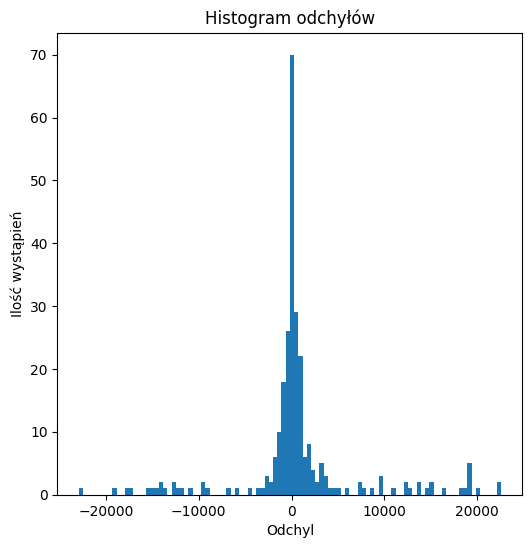

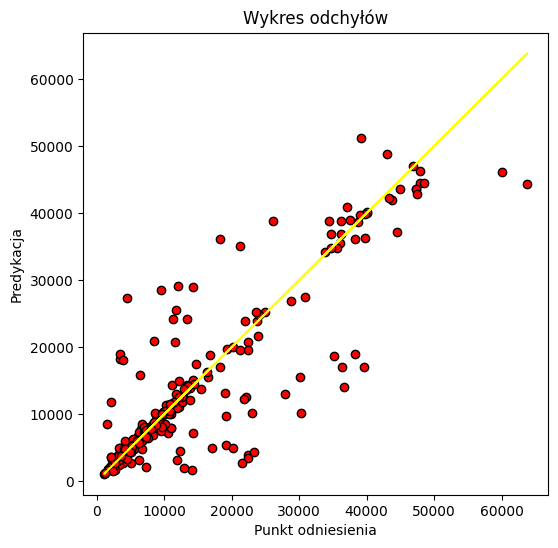

In [45]:
y_pred = grid_search.predict(X_test)


odchyly = y_test - y_pred
plt.figure(figsize=(6, 6))
plt.hist(odchyly, bins=100)
plt.xlabel('Odchyl')
plt.ylabel('Ilość wystąpień')
plt.title("Histogram odchyłów")

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred ,color="red", edgecolors='black')
plt.plot(y_test, y_test, color="yellow")
plt.xlabel('Punkt odniesienia')
plt.ylabel('Predykacja')
plt.title('Wykres odchyłów')

plt.show()

Na histogramie widać, że wykres jest w miarę symetryczny. Istnieją odchyły mające wartość bezwzględną ponad 20 000. Ponad połowa predykacji była bardzo dokładna. Na wykresie odchyłów widać, że ponad połowa predykacji leży blisko przekątnej (przekątna na wykresie oznacza idealną predykację). Rozkład punktów wokół przekątnej też jest w miarę symetryczny.

In [44]:
y_train_stat = grid_search.predict(X_train)

train_mse = mean_squared_error(y_train, y_train_stat)
test_mse = mean_squared_error(y_test, y_pred)

train_r2 = r2_score(y_train, y_train_stat)
test_r2 = r2_score(y_test, y_pred)

print(f'Train MSE: {train_mse}, Train R2: {train_r2}')
print(f'Test MSE: {test_mse}, Test R2: {test_r2}')

Train MSE: 171211.3229664544, Train R2: 0.9987896156415845
Test MSE: 39682906.466534816, Test R2: 0.7615380232841849


-339381.240635

Obliczyliśmy MSE dla predykacji na zbiorze treningowym i testowym. Widać, że wyniki predykacji na zbiorze testowym są gorsze niż dla predykacji na zbiorze treningowym. Dodatkowo obliczyliśmy wspólczynnik determinacji ${R^2}$. Tutaj również współczynnik determinacji dla predykacji na zbiorze testowym jest mniejszy od współczynnika determinacja dla predykacji na zbiorze treningowym. Róźnica wynosi około 0.23. Istnieje prawdopodobieństwo, że model jest przetrenowany.

### Uwagi końcowe

Gdyby dataset był większy, najprawdopodobniej wyniki były lepsze.

